## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

#### Connect to Database

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import config as cfg
from scipy import stats
import requests
from IPython.display import JSON
import json

In [3]:
# Create a connection to the midterm database 
con = psycopg2.connect(database=cfg.DATABASE, 
                       user=cfg.USER, 
                       password=cfg.PASSWORD,
                       host=cfg.HOST, 
                       port=cfg.PORT)
cur = con.cursor()

In [7]:
# get flights data by month from 2018,2019 and save to csv

years = ['2018', '2019']
months = [f'{i:02}'for i in range(1,13)]
for year in years:
    for month in months:
        query = f"SELECT * FROM flights WHERE fl_date LIKE '{year}-{month}%'"

        pandas_response = pd.read_sql_query(query, con)

        pandas_response.to_csv(f'data/{month}_{year}_flights.csv')
        print(f'{month}_{year} complete')
        

01_2018 complete
02_2018 complete
03_2018 complete
04_2018 complete
05_2018 complete
06_2018 complete
07_2018 complete
08_2018 complete
09_2018 complete
10_2018 complete
11_2018 complete
12_2018 complete
01_2019 complete
02_2019 complete
03_2019 complete
04_2019 complete
05_2019 complete
06_2019 complete
07_2019 complete
08_2019 complete
09_2019 complete
10_2019 complete
11_2019 complete
12_2019 complete


In [6]:
pandas_response

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,tail_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,...,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,dup,flights
0,2018-01-01,B6,624,N978JB,12892,LAX,"Los Angeles, CA",12478,JFK,"New York, NY",...,323.0,295.0,2475.0,5.0,0.0,9.0,0.0,15.0,N,1.0
1,2018-01-01,B6,508,N353JB,12478,JFK,"New York, NY",14321,PWM,"Portland, ME",...,86.0,51.0,273.0,NaN,NaN,NaN,NaN,NaN,N,1.0
2,2018-01-01,B6,511,N579JB,11697,FLL,"Fort Lauderdale, FL",10423,AUS,"Austin, TX",...,189.0,161.0,1105.0,8.0,0.0,0.0,0.0,237.0,N,1.0
3,2018-01-01,B6,512,N579JB,10423,AUS,"Austin, TX",11697,FLL,"Fort Lauderdale, FL",...,156.0,136.0,1105.0,205.0,0.0,4.0,0.0,39.0,N,1.0
4,2018-01-01,B6,514,N559JB,12954,LGB,"Long Beach, CA",12478,JFK,"New York, NY",...,301.0,279.0,2465.0,NaN,NaN,NaN,NaN,NaN,N,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601214,2018-01-31,AA,2053,N545UW,11057,CLT,"Charlotte, NC",15304,TPA,"Tampa, FL",...,91.0,74.0,507.0,NaN,NaN,NaN,NaN,NaN,N,1.0
601215,2018-01-31,AA,2053,N545UW,15304,TPA,"Tampa, FL",11057,CLT,"Charlotte, NC",...,103.0,81.0,507.0,NaN,NaN,NaN,NaN,NaN,N,1.0
601216,2018-01-31,AA,2054,N722US,11057,CLT,"Charlotte, NC",14100,PHL,"Philadelphia, PA",...,94.0,71.0,449.0,NaN,NaN,NaN,NaN,NaN,N,1.0
601217,2018-01-31,AA,2055,N971UY,11057,CLT,"Charlotte, NC",13930,ORD,"Chicago, IL",...,136.0,92.0,599.0,NaN,NaN,NaN,NaN,NaN,N,1.0


In [9]:
jan = pd.read_csv('data/01_2019_flights.csv', index_col=0)

# Convert flight date to column to datetime
jan['fl_date'] =  pd.to_datetime(jan['fl_date'], format='%Y/%m/%d')

# Create new column for day of the week ie. 0 = monday
jan['day_of_week'] = jan['fl_date'].dt.dayofweek

jan

In [10]:
jan.shape

(638649, 43)

In [17]:
jan.dtypes

fl_date                datetime64[ns]
mkt_unique_carrier             object
branded_code_share             object
mkt_carrier                    object
mkt_carrier_fl_num              int64
op_unique_carrier              object
tail_num                       object
op_carrier_fl_num               int64
origin_airport_id               int64
origin                         object
origin_city_name               object
dest_airport_id                 int64
dest                           object
dest_city_name                 object
crs_dep_time                    int64
dep_time                      float64
dep_delay                     float64
taxi_out                      float64
wheels_off                    float64
wheels_on                     float64
taxi_in                       float64
crs_arr_time                    int64
arr_time                      float64
arr_delay                     float64
cancelled                     float64
cancellation_code              object
diverted    

#### **Task 1**: 
Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [167]:
week1 = jan[(jan['fl_date'] >= '2019-01-01') & (jan['fl_date'] <= '2019-01-07')].copy()
x = week1['arr_delay'].isnull()
x.value_counts()

False    145053
True       1432
Name: arr_delay, dtype: int64

In [161]:
week1.dropna(inplace=True,subset=['arr_delay'])

In [163]:
week1[week1['arr_delay'].isnull()]


,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,day_of_week


<AxesSubplot:>

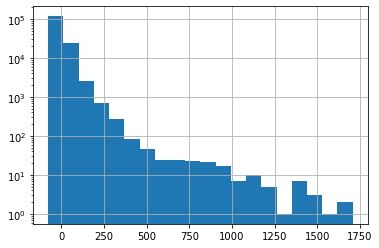

In [171]:
week1['arr_delay'].hist(bins=20, log=True)

In [179]:
value_counts = week1['arr_delay'].value_counts()
value_counts.head(50)

-9.0     3872
-10.0    3803
-12.0    3789
-11.0    3740
-8.0     3712
-7.0     3705
-14.0    3586
-15.0    3584
-13.0    3572
-6.0     3571
-5.0     3542
-16.0    3465
-4.0     3369
-17.0    3207
-3.0     3112
-18.0    3010
-2.0     3008
-1.0     2858
 0.0     2803
-19.0    2788
-20.0    2588
 1.0     2527
-21.0    2366
 2.0     2279
 3.0     2262
-22.0    2146
-23.0    2062
 4.0     1993
 5.0     1924
-24.0    1830
 6.0     1817
 7.0     1724
-25.0    1674
 8.0     1665
-26.0    1593
 9.0     1531
-27.0    1385
 10.0    1376
 11.0    1370
 12.0    1265
-28.0    1200
 13.0    1154
-29.0    1142
 14.0    1088
 15.0    1040
 16.0     975
-30.0     965
-31.0     924
 17.0     916
 18.0     836
Name: arr_delay, dtype: int64

In [218]:
week1['arr_delay'].min()

-76.0

In [164]:
normal_test = stats.normaltest(week1['arr_delay'].sample(100), nan_policy='omit')
normal_test

NormaltestResult(statistic=208.9011370260165, pvalue=4.34204643039079e-46)

In [165]:
normal_test = stats.normaltest(week1['arr_delay'], nan_policy='omit')
normal_test

NormaltestResult(statistic=229624.47239632078, pvalue=0.0)

In [174]:
print(f"Arrival delay Mean: {week1['arr_delay'].mean()}")
print(f"Arrival delay Median: {week1['arr_delay'].median()}")
print(f"Arrival delay Standard Deviation: {week1['arr_delay'].std()}")

Arrival delay Mean: 3.2412014918684893
Arrival delay Median: -6.0
Arrival delay Standard Deviation: 47.96985335842532


In [170]:
anderson_test = stats.anderson(week1['arr_delay'].sample(1000), dist='expon')
anderson_test

AndersonResult(statistic=nan, critical_values=array([0.921, 1.077, 1.34 , 1.605, 1.956]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

#### **Task 2**: 
Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [215]:
# loop through each month. Calculate mean and median of arr_delay. build dataframe with monthstats
years = ['2018', '2019']
months = [f'{i:02}'for i in range(1,13)]
monthly_stats = []
for year in years:
    for month in months:
        month_df = pd.read_csv(f'data/{month}_{year}_flights.csv', index_col=0)
        month_df.dropna(inplace=True,subset=['arr_delay'])
        monthly_stats.append({'year': year,'month':month, 'mean': month_df['arr_delay'].mean(),'median': month_df['arr_delay'].median()})

monthly_stat_df = pd.DataFrame(monthly_stats)

/home/kyle/anaconda3/envs/Python3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/kyle/anaconda3/envs/Python3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [217]:
monthly_stat_df.sort_values(['year', 'mean'], ascending=False)

,year,month,mean,median
17,2019,06,11.993984,-4.0
13,2019,02,9.306549,-4.0
18,2019,07,8.971920,-6.0
19,2019,08,7.745285,-6.0
16,2019,05,7.031468,-6.0
23,2019,12,6.442686,-6.0
12,2019,01,4.714467,-7.0
15,2019,04,4.710994,-7.0
14,2019,03,3.487239,-7.0
21,2019,10,2.650218,-7.0


#### **Task 3**: 
Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [241]:
jan_2019 = pd.read_csv('data/01_2019_flights.csv', index_col=0)
# Convert flight date to column to datetime
jan_2019['fl_date'] =  pd.to_datetime(jan_2019['fl_date'], format='%Y/%m/%d')


In [12]:
def get_wwo_weather(city, date, time):
    params = {'q':city,
              'date': date,
              'tp':1, 
              'format': 'json',
              'key': cfg.WEATHER_KEY
             }
    url = "https://api.worldweatheronline.com/premium/v1/past-weather.ashx"
    response = requests.get(url=url, params=params)
    return response

In [13]:
response = get_wwo_weather('Los Angeles, CA', '2019-01-01', '16:30')

In [22]:
result  = response.json()

In [30]:
result_df = pd.json_normalize(result)
result_df

,data.request,data.weather
0,"[{'type': 'City', 'query': 'Los Angeles, Unite...","[{'date': '2019-01-01', 'astronomy': [{'sunris..."


In [10]:
JSON(result)

<IPython.core.display.JSON object>

In [2]:
def get_noaa_weather():
     # params = {'q':city,
     #          'date': date,
     #          'tp':1, 
     #          'format': 'json',
     #          'key': cfg.WEATHER_KEY
     #         }
    headers = {'token': cfg.NOAA_KEY}
    url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/datasets"
    response = requests.get(url=url, headers=headers)
    
    return response

In [4]:
res= get_noaa_weather()

In [6]:
result = res.json()


In [7]:
JSON(result)

<IPython.core.display.JSON object>

#### **Task 4**: 
How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

#### **Task 5**:
What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

#### **Task 6**: 
How many states cover 50% of US air traffic? 

#### **Task 7**: 
Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: 
When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

#### **Task 9**: 
Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: 
Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?